# Import

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
%%capture
import tensorflow as tf
import numpy as np
import cv2
import os

from pycocotools.coco import COCO
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D
from tensorflow.keras.layers import BatchNormalization, Conv2DTranspose
from tensorflow.keras.layers import Concatenate, ReLU
from tensorflow.keras.models import Model


# Semantic Segmentation Architecture

In [3]:
IMG_SIZE = 224
BATCH_SIZE = 4

class CocoSemanticGenerator(tf.keras.utils.Sequence):

    def __init__(self, image_dir, ann_file, augment=False):
        self.coco = COCO(ann_file)
        self.image_dir = image_dir
        self.ids = list(self.coco.imgs.keys())
        self.augment = augment

    def __len__(self):
        return len(self.ids)//BATCH_SIZE

    def color_aug(self, img):
        if np.random.rand() < 0.5:
            img = tf.image.random_brightness(img, 0.2)
        if np.random.rand() < 0.5:
            img = tf.image.random_contrast(img, 0.8,1.2)
        if np.random.rand() < 0.5:
            img = tf.image.random_saturation(img,0.8,1.2)
        return img

    def __getitem__(self, idx):

        batch_ids = self.ids[idx*BATCH_SIZE:(idx+1)*BATCH_SIZE]

        images = []
        masks = []

        for img_id in batch_ids:

            info = self.coco.loadImgs(img_id)[0]
            path = os.path.join(self.image_dir, info['file_name'])

            img = cv2.imread(path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img,(IMG_SIZE,IMG_SIZE))/255.0

            if self.augment:
                img = self.color_aug(img)

            mask = np.zeros((info['height'],info['width']),dtype=np.uint8)

            ann_ids = self.coco.getAnnIds(imgIds=img_id)
            anns = self.coco.loadAnns(ann_ids)

            # SINGLE CLASS
            for ann in anns:
                m = self.coco.annToMask(ann)
                mask[m==1] = 1

            mask = cv2.resize(mask,(IMG_SIZE,IMG_SIZE),interpolation=cv2.INTER_NEAREST)
            mask = np.expand_dims(mask,-1)

            images.append(img)
            masks.append(mask)

        return np.array(images), np.array(masks)


In [4]:
def convolution_operation(entered_input, filters=64):

    conv1 = Conv2D(filters,(3,3),padding="same")(entered_input)
    batch_norm1 = BatchNormalization()(conv1)
    act1 = ReLU()(batch_norm1)

    conv2 = Conv2D(filters,(3,3),padding="same")(act1)
    batch_norm2 = BatchNormalization()(conv2)
    act2 = ReLU()(batch_norm2)

    return act2

In [5]:
def encoder(entered_input, filters=64):

    enc = convolution_operation(entered_input,filters)
    pool = MaxPooling2D(strides=(2,2))(enc)

    return enc,pool

In [6]:
def decoder(entered_input, skip, filters=64):

    up = Conv2DTranspose(filters,(2,2),strides=2,padding="same")(entered_input)
    merge = Concatenate()([up,skip])
    out = convolution_operation(merge,filters)

    return out

In [7]:
def UNet():

    inputs = Input((224,224,3))

    enc1,pool1 = encoder(inputs,64)
    enc2,pool2 = encoder(pool1,128)
    enc3,pool3 = encoder(pool2,256)
    enc4,pool4 = encoder(pool3,512)

    bridge = convolution_operation(pool4,1024)

    dec4 = decoder(bridge,enc4,512)
    dec3 = decoder(dec4,enc3,256)
    dec2 = decoder(dec3,enc2,128)
    dec1 = decoder(dec2,enc1,64)

    # single-class output
    outputs = Conv2D(1,(1,1),activation="sigmoid")(dec1)

    model = Model(inputs,outputs)
    return model

In [8]:
from tensorflow.keras.models import load_model

model = load_model("/content/drive/MyDrive/PLANKTON/data/instance/instance-t20.v2i.coco-segmentation/unet_augmented.h5", compile=False)

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 224, 224,  │      1,792 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 224, 224,  │        256 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu (ReLU)        │ (None, 224, 224,  │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 224, 224,  │     36,928 │ re_lu[0][0]       │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 224, 224,  │        256 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_1 (ReLU)      │ (None, 224, 224,  │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 112, 112,  │          0 │ re_lu_1[0][0]     │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 112, 112,  │     73,856 │ max_pooling2d[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 112, 112,  │        512 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_2 (ReLU)      │ (None, 112, 112,  │          0 │ batch_normalizat… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 112, 112,  │    147,584 │ re_lu_2[0][0]     │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 112, 112,  │        512 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_3 (ReLU)      │ (None, 112, 112,  │          0 │ batch_normalizat… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 56, 56,    │          0 │ re_lu_3[0][0]     │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 56, 56,    │    295,168 │ max_pooling2d_1[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 56, 56,    │      1,024 │ conv2d_4[0][0]  

 Total params: 31,055,297 (118.47 MB)

 Trainable params: 31,043,521 (118.42 MB)

 Non-trainable params: 11,776 (46.00 KB)

# Train

In [9]:
BASE_PATH = "/content/drive/MyDrive/PLANKTON/data/instance/instance-t20.v2i.coco-segmentation"

train_aug_gen = CocoSemanticGenerator(
    image_dir=f"{BASE_PATH}/train/images",
    ann_file=f"{BASE_PATH}/train/_annotations.coco.json",
    augment=True
)

valid_gen = CocoSemanticGenerator(
    image_dir=f"{BASE_PATH}/valid/images",
    ann_file=f"{BASE_PATH}/valid/_annotations.coco.json",
    augment=False
)

loading annotations into memory...
Done (t=0.77s)
creating index...
index created!
loading annotations into memory...
Done (t=0.38s)
creating index...
index created!


In [10]:
model.fit(
    train_aug_gen,
    validation_data=valid_gen,
    epochs=20
)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 121s 2s/step - accuracy: 0.9784 - loss: 0.0811 - val_accuracy: 0.9510 - val_loss: 0.3249
Epoch 2/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 9s 295ms/step - accuracy: 0.9693 - loss: 0.0960 - val_accuracy: 0.9660 - val_loss: 0.1147
Epoch 3/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 10s 307ms/step - accuracy: 0.9816 - loss: 0.0684 - val_accuracy: 0.9665 - val_loss: 0.1049
Epoch 4/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 10s 305ms/step - accuracy: 0.9751 - loss: 0.0833 - val_accuracy: 0.9652 - val_loss: 0.1012
Epoch 5/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 9s 294ms/step - accuracy: 0.9810 - loss: 0.0652 - val_accuracy: 0.9648 - val_loss: 0.1039
Epoch 6/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 9s 289ms/step - accuracy: 0.9848 - loss: 0.0575 - val_accuracy: 0.9686 - val_loss: 0.0921
Epoch 7/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 9s 289ms/step - accuracy: 0.9823 - loss: 0.0604 - val_accuracy: 0.9646 - val_loss: 0.1111
Epoch 8/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 9s 283ms/step - accuracy: 0.9817 - loss: 0.0597 - val_accuracy: 0

# Val

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Text(0.5, 1.0, 'Prediction')

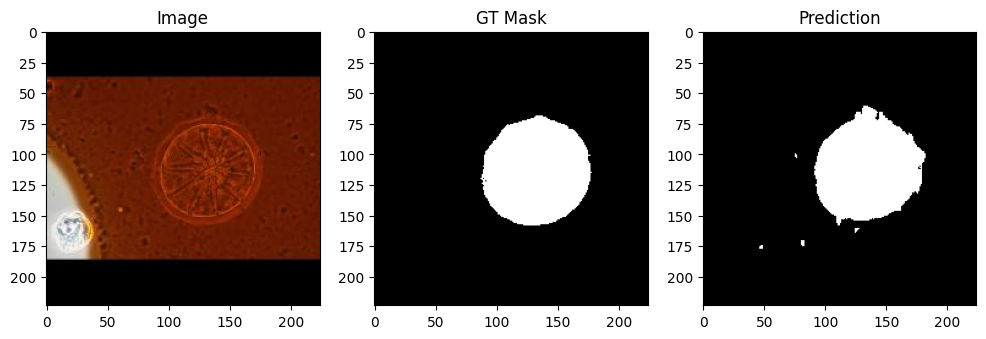

In [11]:
import matplotlib.pyplot as plt

imgs, masks = valid_gen[0]
preds = model.predict(imgs)

plt.figure(figsize=(12,4))

plt.subplot(1,3,1)
plt.imshow(imgs[0])
plt.title("Image")

plt.subplot(1,3,2)
plt.imshow(masks[0].squeeze(), cmap="gray")
plt.title("GT Mask")

plt.subplot(1,3,3)
plt.imshow((preds[0]>0.5).squeeze(), cmap="gray")
plt.title("Prediction")

In [12]:
import tensorflow as tf
import numpy as np

def dice_score_np(y_true, y_pred, smooth=1e-6):

    y_true = y_true.flatten()
    y_pred = y_pred.flatten()

    intersection = np.sum(y_true * y_pred)

    return (2. * intersection + smooth) / (np.sum(y_true) + np.sum(y_pred) + smooth)

In [13]:
import matplotlib.pyplot as plt

def show_validation_analysis(model, valid_gen, num_samples=3):

    imgs, masks = valid_gen[0]
    preds = model.predict(imgs)

    for i in range(num_samples):

        gt = masks[i].squeeze()
        pred = (preds[i] > 0.5).astype(np.uint8).squeeze()

        # 🔥 Hitung Dice per sample
        dice = dice_score_np(gt, pred)

        # 🔥 Error analysis
        FP = np.logical_and(pred==1, gt==0)   # False Positive
        FN = np.logical_and(pred==0, gt==1)   # False Negative

        # 🔥 Overlay error
        overlay = imgs[i].copy()
        overlay[FP] = [1,0,0]   # merah = FP
        overlay[FN] = [0,0,1]   # biru = FN

        plt.figure(figsize=(15,4))

        # Image
        plt.subplot(1,4,1)
        plt.imshow(imgs[i])
        plt.title("Image")
        plt.axis("off")

        # Ground Truth
        plt.subplot(1,4,2)
        plt.imshow(gt, cmap="gray")
        plt.title("Ground Truth")
        plt.axis("off")

        # Prediction
        plt.subplot(1,4,3)
        plt.imshow(pred, cmap="gray")
        plt.title(f"Prediction | Dice={dice:.3f}")
        plt.axis("off")

        # Error Overlay
        plt.subplot(1,4,4)
        plt.imshow(overlay)
        plt.title("Error Map (Red=FP, Blue=FN)")
        plt.axis("off")

        plt.show()

In [ ]:
def dice_score(y_true, y_pred, smooth=1e-6):

    y_true = tf.cast(tf.reshape(y_true,[-1]), tf.float32)
    y_pred = tf.cast(tf.reshape(y_pred,[-1]), tf.float32)

    intersection = tf.reduce_sum(y_true*y_pred)

    return (2*intersection+smooth)/(tf.reduce_sum(y_true)+tf.reduce_sum(y_pred)+smooth)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


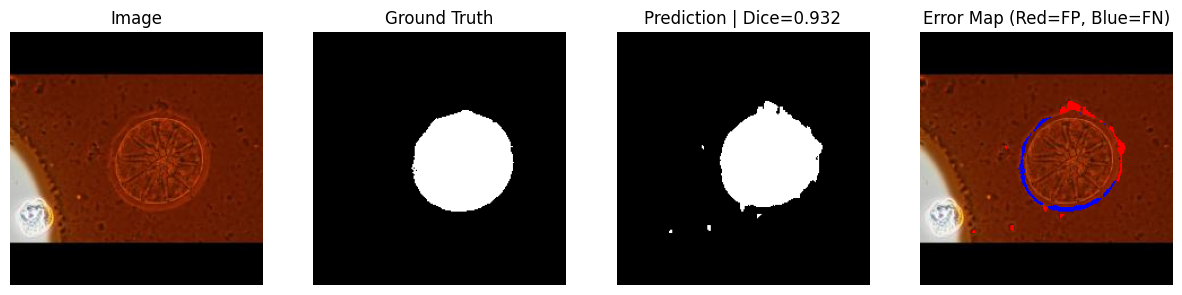

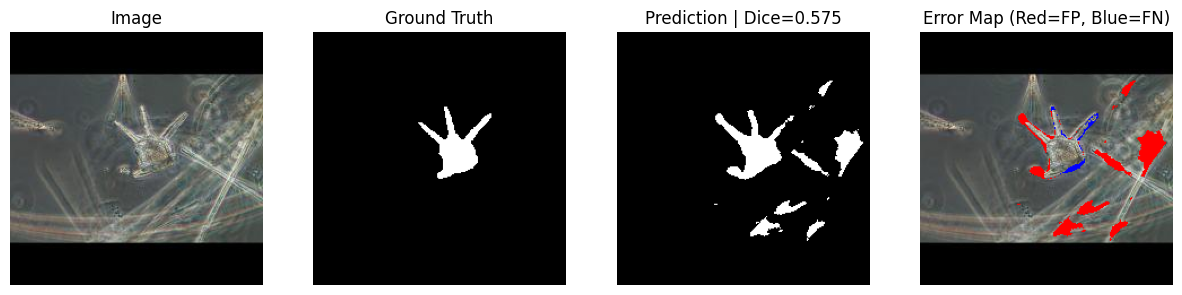

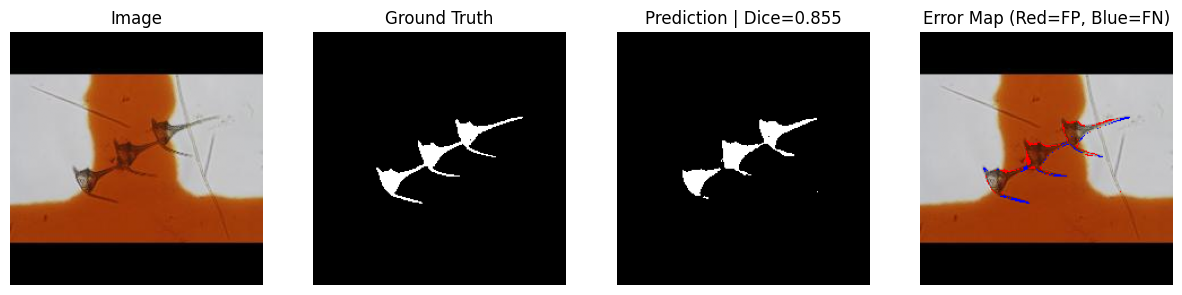

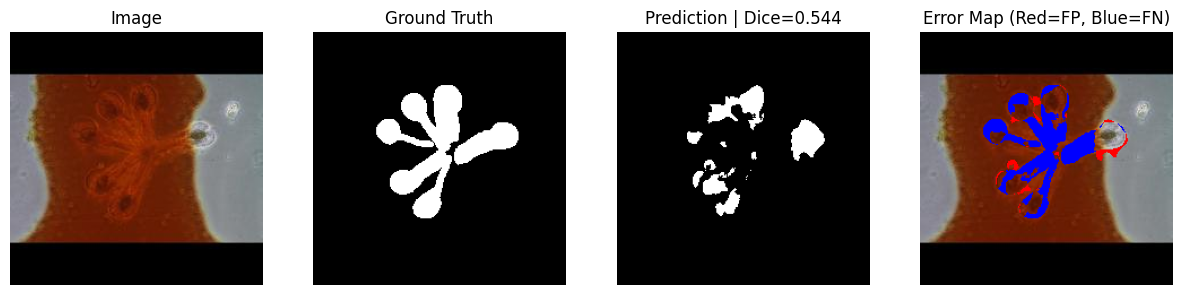

IndexError: index 4 is out of bounds for axis 0 with size 4

In [14]:
show_validation_analysis(model, valid_gen, num_samples=5)

In [ ]:
model.save("unet_augmented.keras")